## Import libraries

In [1]:
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import re
import gc
import cytopus as cp
import Spectra
import gseapy as gp
import pickle

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Site information

In [2]:
sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")
pheno_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/A6K/Phenotypes/Subject_Data.A6K.BRONZE.Phenotypes.2024_freeze_3.utf8.txt", sep="\t")
pheno_diab_raw = pd.read_csv("/project/tishkofflab/projects/danihar_biomarker_project/olink/data/phenotypes/v1/DF_step2.txt", sep="\t")

/tmp/ipykernel_87914/2595490462.py:1: DtypeWarning: Columns (4,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,130,131,132,133,134,135,136,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,185,187,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")
/tmp/ipykernel_87914/2595490462.py:2: DtypeWarning: Columns (4,5,6,10,12,73,74,108) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno_info_raw = pd

In [3]:
site_collect = sample_info_raw[['ID:topmed',
                                'ID:field',
                                'Subject_Information:Ethnicity::str',
                                'Collection_Information:Latitude::num::deg',
                                'Collection_Information:Longitude::num::deg',
                                'Collection_Information:Site::str',
                                'Collection_Information:Date::date',
                                'Categorization:Lifestyle:Subsistence_Practice::str',
                                'Categorization:Lifestyle:Subsistence_Practice:Notes::str']]

site_collect = site_collect.rename(columns={'ID:topmed': 'TID',
                                            'ID:field': 'FID',
                                            'Subject_Information:Ethnicity::str': 'Ethnicity',
                                            'Collection_Information:Latitude::num::deg': 'latitude',
                                            'Collection_Information:Longitude::num::deg': 'longitude',
                                            'Collection_Information:Site::str': 'site',
                                            'Collection_Information:Date::date': 'date',
                                            'Categorization:Lifestyle:Subsistence_Practice::str': 'subsistence'})

## Get cell types

In [8]:
rna_ctl = sc.read_h5ad("write/MR_ctl_raw.umap.clean.h5ad")
rna_lps = sc.read_h5ad("write/MR_lps_raw.umap.clean.h5ad")

In [9]:
rna_umap = sc.concat([rna_ctl, rna_lps])

## Format data for Spectra

In [6]:
rna_raw = sc.read_h5ad("write/MR_all_raw.h5ad")

In [10]:
rna_raw

View of AnnData object with n_obs × n_vars = 569956 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'donor_id', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity'

In [8]:
rna_umap

AnnData object with n_obs × n_vars = 569956 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'donor_id', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity', 'leiden', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'lineage', 'lineage_match'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'raw_counts'

In [9]:
rna_raw = rna_raw[rna_umap.obs_names]

In [12]:
rna_raw.obs[['FCluster_names', 'Cluster_names', 'SCluster_names']] = rna_umap.obs[['FCluster_names', 'Cluster_names', 'SCluster_names']]

/tmp/ipykernel_216978/3400460715.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_raw.obs[['FCluster_names', 'Cluster_names', 'SCluster_names']] = rna_umap.obs[['FCluster_names', 'Cluster_names', 'SCluster_names']]


In [14]:
# map cytopus names to inferred cell types
ctype_map = {"B cells": "B",
             "CD4+ T cells" : "CD4-T",
             "DN T cells" : "DNT",            
             "MAIT cells" : "MAIT",
             "Myeloid cells" : "M",
             "NK cells" : "NK",
             "Progenitor cells" : "Progenitor",
             "TRAV1-2- CD8+ T cells" : "CD8-T",
             "gd T cells" : "gdT"}

rna_raw.obs['cytopus_names'] = rna_raw.obs['Cluster_names'].apply(lambda x: ctype_map[x])

In [18]:
rna_med_counts = np.median(rna_raw.obs['total_counts'])

In [19]:
rna_med_counts

3393.0

In [20]:
sc.pp.normalize_total(rna_raw, target_sum=rna_med_counts)
sc.pp.log1p(rna_raw)

In [22]:
sc.pp.highly_variable_genes(rna_raw, n_top_genes=10000)

In [24]:
rna_raw.write("write/MR_all.spectra_in.h5ad")

## Project Multiome onto RNA-seq results

In [2]:
# read in RNA-seq Spectra results
#sp_model = sc.read_h5ad("../../test/test123/write/qc_020725.spectra_out.4k.h5ad")
with open('../../test/test123/spectra_model.032625.pkl', 'rb') as file:
        sp_model = pickle.load(file)

In [4]:
spectra = sc.read_h5ad("../../test/test123/write/qc_020725.spectra_out.4k.h5ad", backed='r')

In [28]:
spectra.uns['SPECTRA_factors']

(41, 10560)

In [5]:
rna_raw = sc.read_h5ad("write/MR_all.spectra_in.h5ad")

In [6]:
rna_raw_mc = rna_raw[(rna_raw.obs['cytopus_names']=="M") & (rna_raw.obs['COND']=="CTL")]

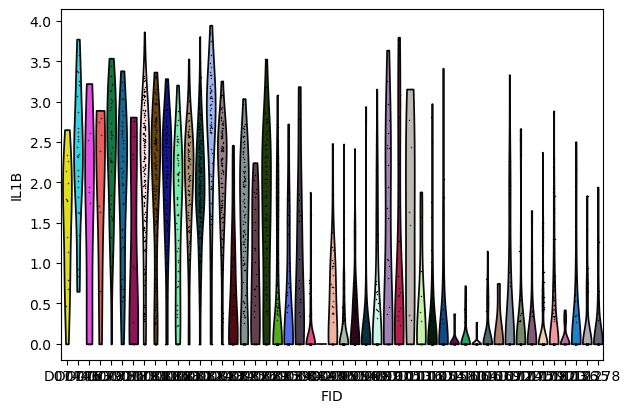

In [25]:
sc.pl.violin(rna_raw_mc[(rna_raw_mc.obs['Ethnicity']=="Fulani") & (rna_raw_mc.obs['site']=="Ntambang")], keys=['IL1B'], groupby='FID')

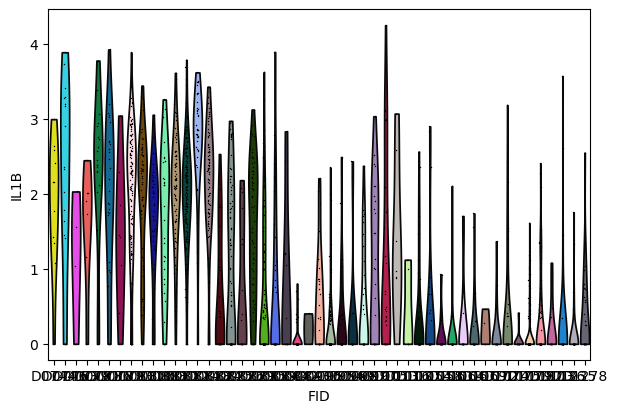

In [26]:
sc.pl.violin(rna_raw_mc[(rna_raw_mc.obs['Ethnicity']=="Fulani") & (rna_raw_mc.obs['site']=="Sabga")], keys=['IL1B'], groupby='FID')

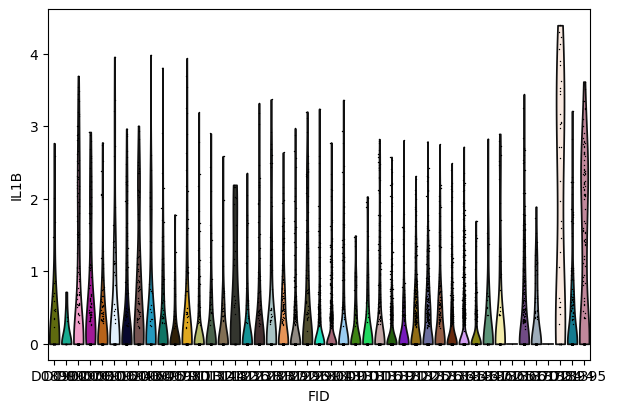

In [13]:
sc.pl.violin(rna_raw_mc[rna_raw_mc.obs['Ethnicity']=="Tikari"], keys=['IL1B'], groupby='FID')

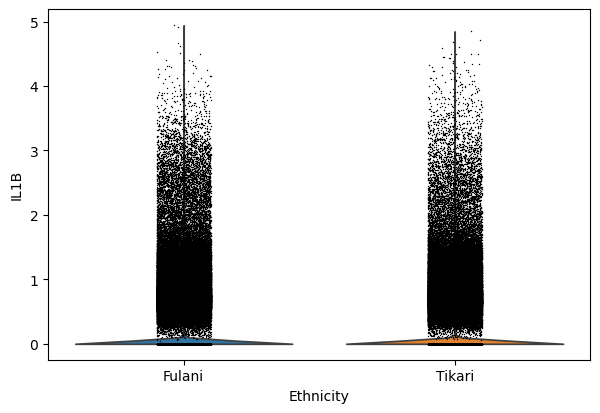

In [9]:
sc.pl.violin(rna_raw, keys=['IL1B'], groupby='Ethnicity')

In [7]:
f24_scores = rna_raw.X[:,spectra.var['spectra_vocab']].dot(spectra.uns['SPECTRA_factors'][24,:])

In [62]:
rna_ctl = sc.read_h5ad("write/MR_ctl_raw.umap.clean.h5ad", backed='r')
rna_lps = sc.read_h5ad("write/MR_lps_raw.umap.clean.h5ad", backed='r')

In [8]:
rna_raw.obs['f24_scores'] = f24_scores

In [188]:
foo = rna_raw[(rna_raw.obs['Cluster_names']=="Myeloid cells") & (rna_raw.obs['COND']=="CTL")].obs.groupby(['Ethnicity','FID'])['f24_scores'].apply(lambda x: np.mean(x > 1.5))

In [189]:
foo_cnts = rna_raw[(rna_raw.obs['Cluster_names']=="Myeloid cells") & (rna_raw.obs['COND']=="CTL")].obs.groupby(['Ethnicity','FID']).size()

In [190]:
bar = foo.to_frame().reset_index().merge(site_collect[['FID','site','date']]).sort_values('date')

In [191]:
bar_cnts = foo_cnts.to_frame().reset_index().merge(site_collect[['FID','site','date']]).sort_values('date')

In [192]:
bar = bar[~bar['f24_scores'].isna()]

In [193]:
bar_cnts = bar_cnts[bar_cnts[0] > 0]

<Axes: xlabel='0', ylabel='f24_scores'>

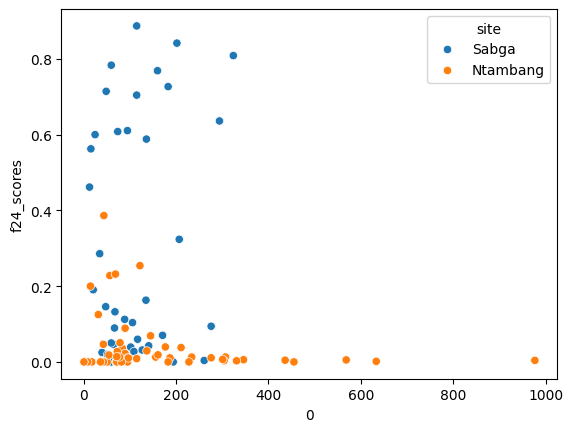

In [195]:
sns.scatterplot(bar_cnts.merge(bar), x=0, y='f24_scores', hue='site')

In [18]:
ax = sns.boxplot(bar, x='date', y='f24_scores', hue='Ethnicity')
ax.tick_params(axis='x', labelrotation=90) 

NameError: name 'bar' is not defined

In [176]:
pd.crosstab(bar['Ethnicity'], bar['date'])

date       2015-06-14 00:00:00  2015-06-15 00:00:00  2015-06-16 00:00:00  \
Ethnicity                                                                  
Fulani                       2                    5                    8   
Tikari                       0                    0                    0   

date       2015-06-17 00:00:00  2015-07-20 00:00:00  2015-07-21 00:00:00  \
Ethnicity                                                                  
Fulani                       9                    1                    0   
Tikari                       0                    2                    5   

date       2015-07-22 00:00:00  2015-07-23 00:00:00  2015-07-27 00:00:00  \
Ethnicity                                                                  
Fulani                       2                    1                    5   
Tikari                       1                    4                    0   

date       2015-07-28 00:00:00  2015-07-29 00:00:00  2015-07-30 00:00:00  \
Ethnicity                                                                  
Fulani                       3                    9                    2   
Tikari                       0                    0                    2   

date       2015-08-06 00:00:00  2015-08-07 00:00:00  2015-08-09 00:00:00  \
Ethnicity                                                                  
Fulani                       0                    0                    1   
Tikari                       1                    1                    2   

date       2015-08-10 00:00:00  2015-08-11 00:00:00  2015-08-12 00:00:00  
Ethnicity                                                                 
Fulani                       1                    0                    0  
Tikari                       8                   11                    8

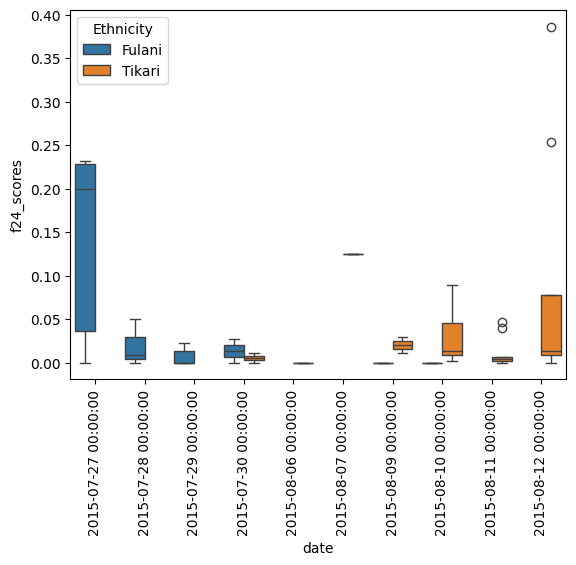

In [171]:
ax = sns.boxplot(bar[bar['site']=="Ntambang"], x='date', y='f24_scores', hue='Ethnicity')
ax.tick_params(axis='x', labelrotation=90) 

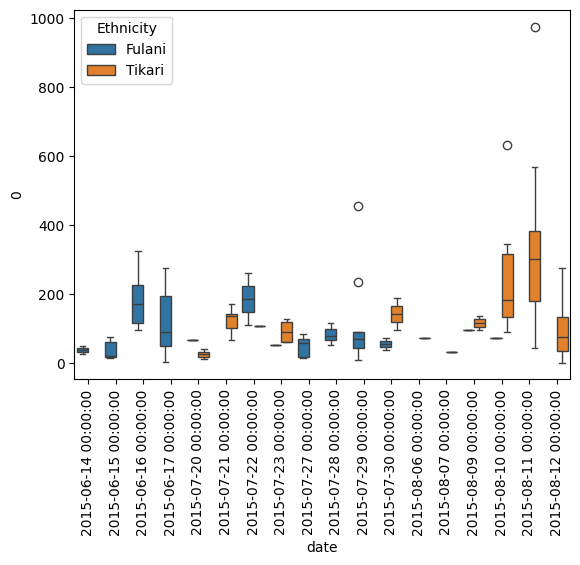

In [165]:
ax = sns.boxplot(bar_cnts, x='date', y=0, hue='Ethnicity')
ax.tick_params(axis='x', labelrotation=90) 

<Axes: xlabel='f24_scores', ylabel='Count'>

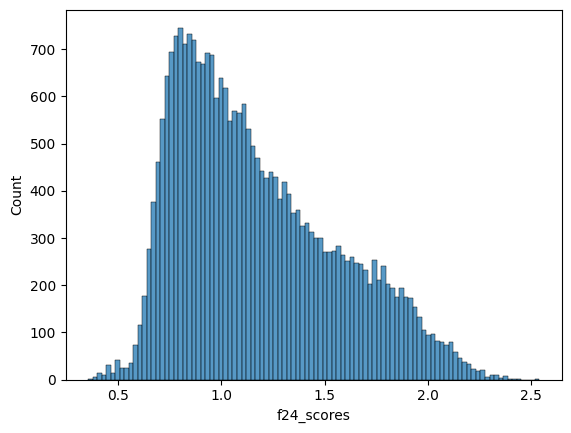

In [76]:
sns.histplot(rna_raw[rna_raw.obs['Cluster_names']=="Myeloid cells"].obs['f24_scores'], bins=100)

<Axes: xlabel='f24_scores', ylabel='Count'>

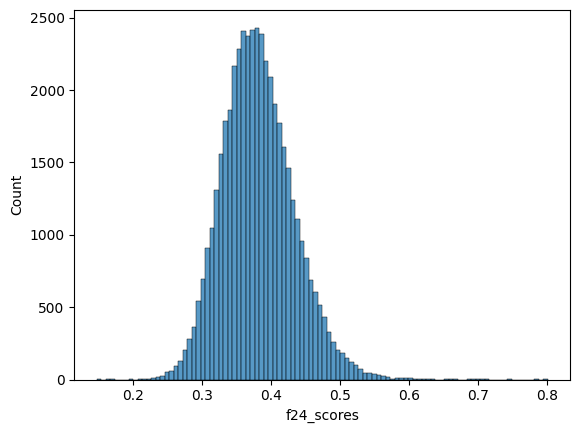

In [77]:
sns.histplot(rna_raw[rna_raw.obs['Cluster_names']=="B cells"].obs['f24_scores'], bins=100)

In [9]:
rna_raw.obs['site'] = rna_raw.obs.reset_index()[['index','FID']].merge(site_collect[['FID','site']]).set_index('index')['site']

In [10]:
rna_raw.obs['date'] = rna_raw.obs.reset_index()[['index','FID']].merge(site_collect[['FID','date']]).set_index('index')['date']

In [11]:
spectra_mc = spectra[(spectra.obs['cytopus_names']=="M") & (spectra.obs['COND']=="CTL")].to_memory()

In [12]:
spectra_mc.obs['site'] = spectra_mc.obs.reset_index()[['index','FID']].merge(site_collect[['FID','site']]).set_index('index')['site']

In [13]:
spectra_mc.obs['date'] = spectra_mc.obs.reset_index()[['index','FID']].merge(site_collect[['FID','date']]).set_index('index')['date']

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


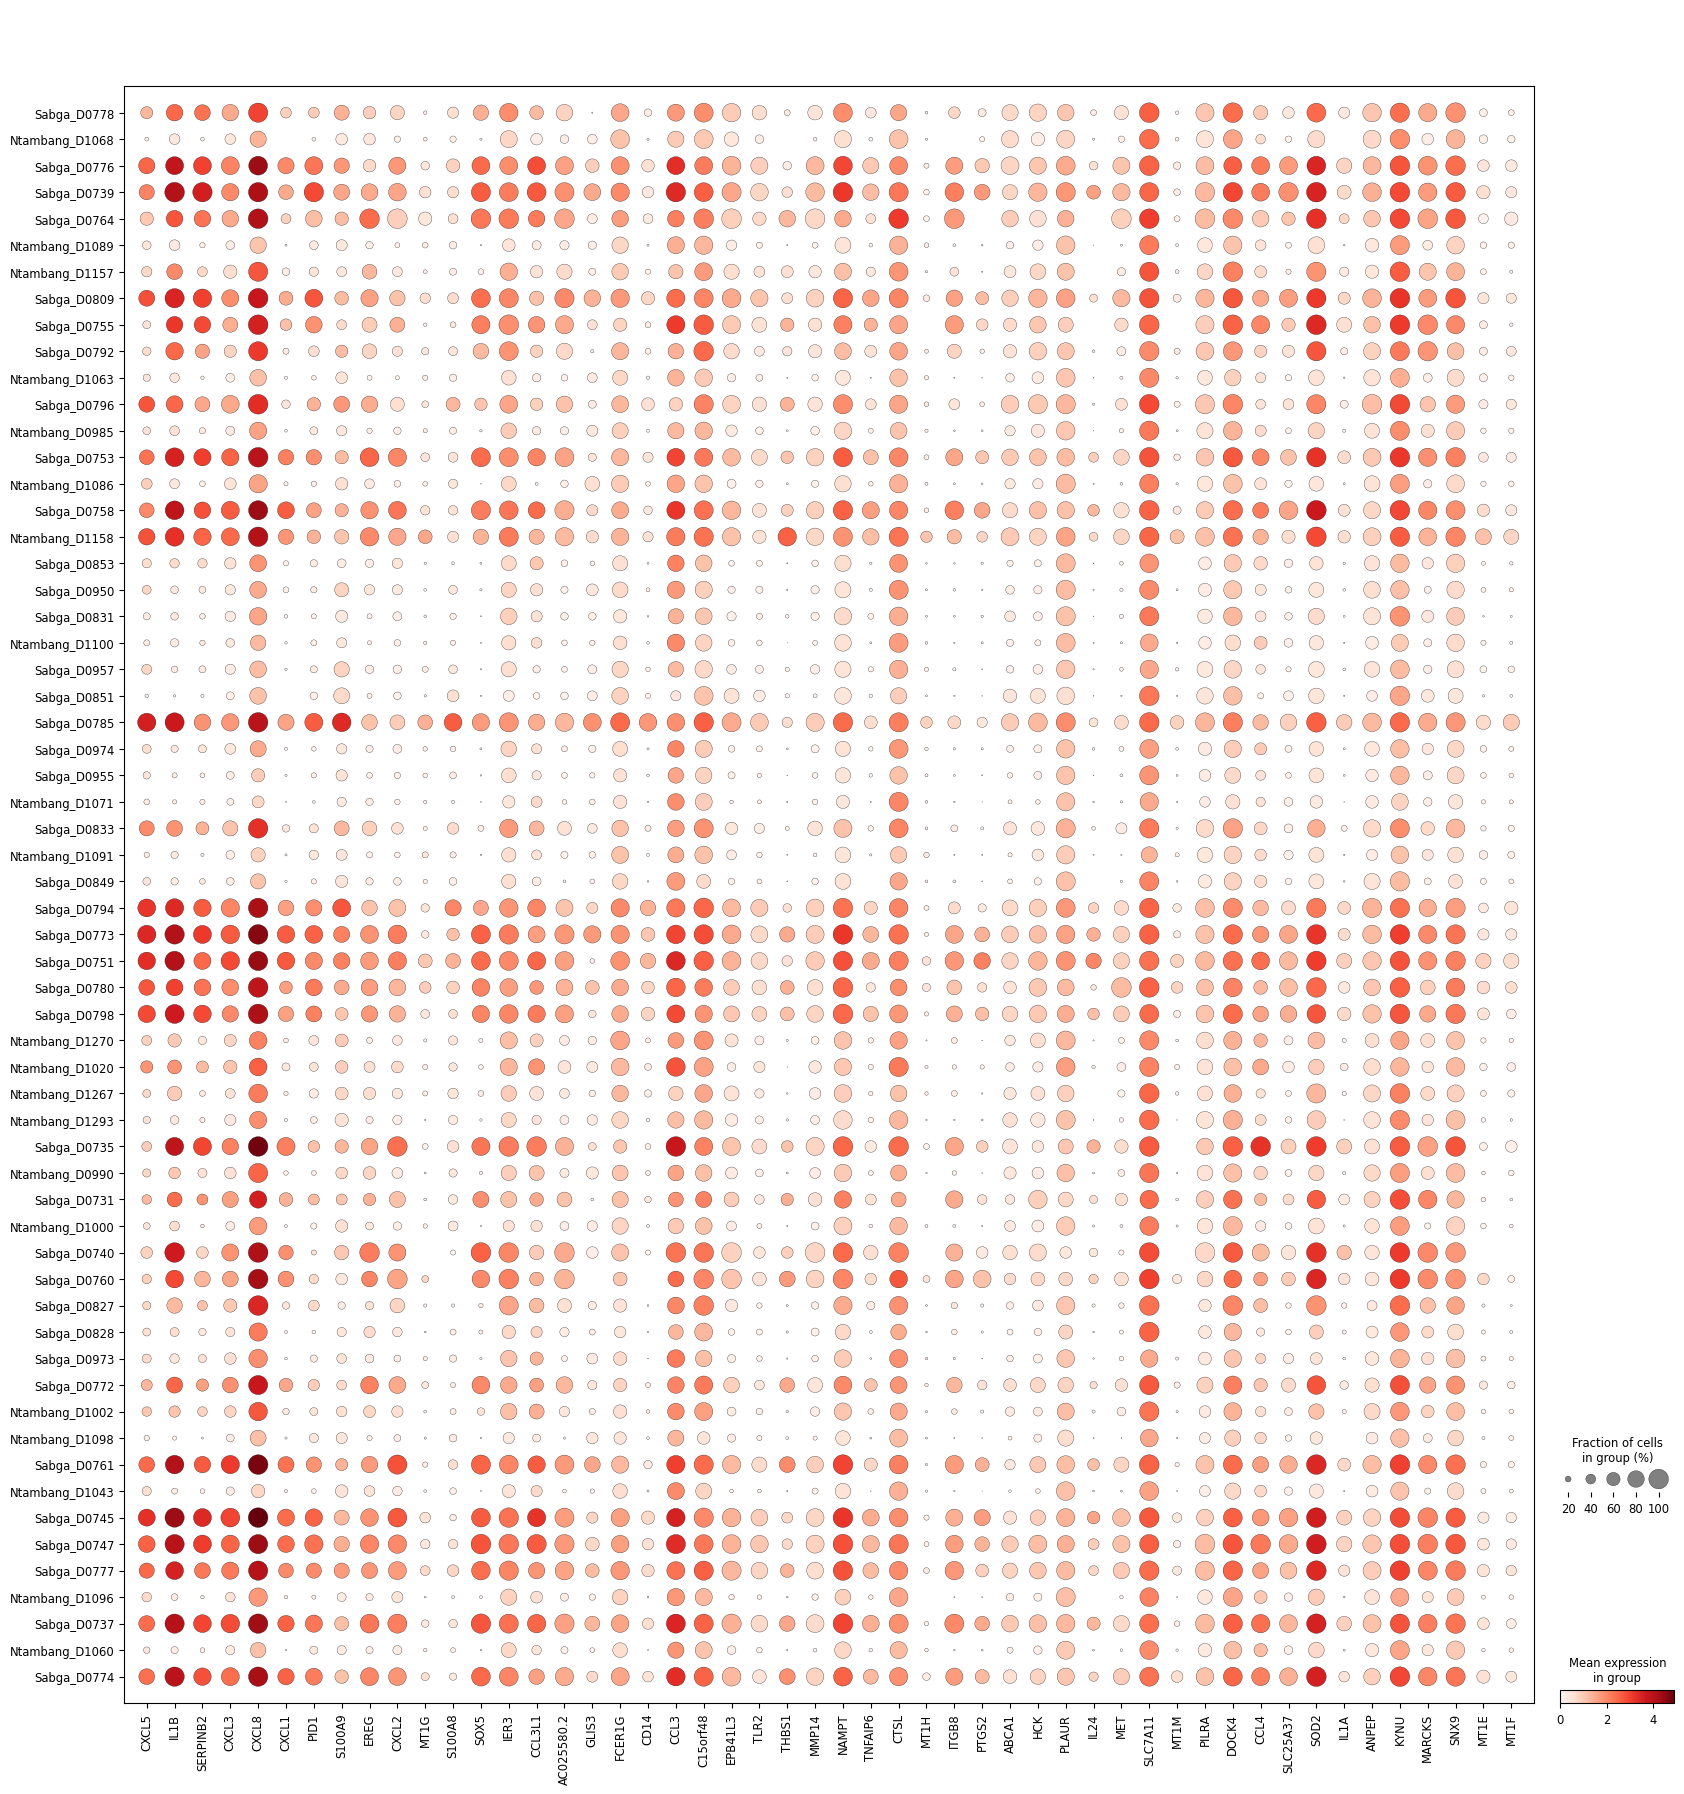

In [14]:
sc.pl.dotplot(spectra_mc[spectra_mc.obs['Ethnicity']=="Fulani"],var_names=spectra.uns['SPECTRA_markers'][24], groupby=['site','FID'])

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


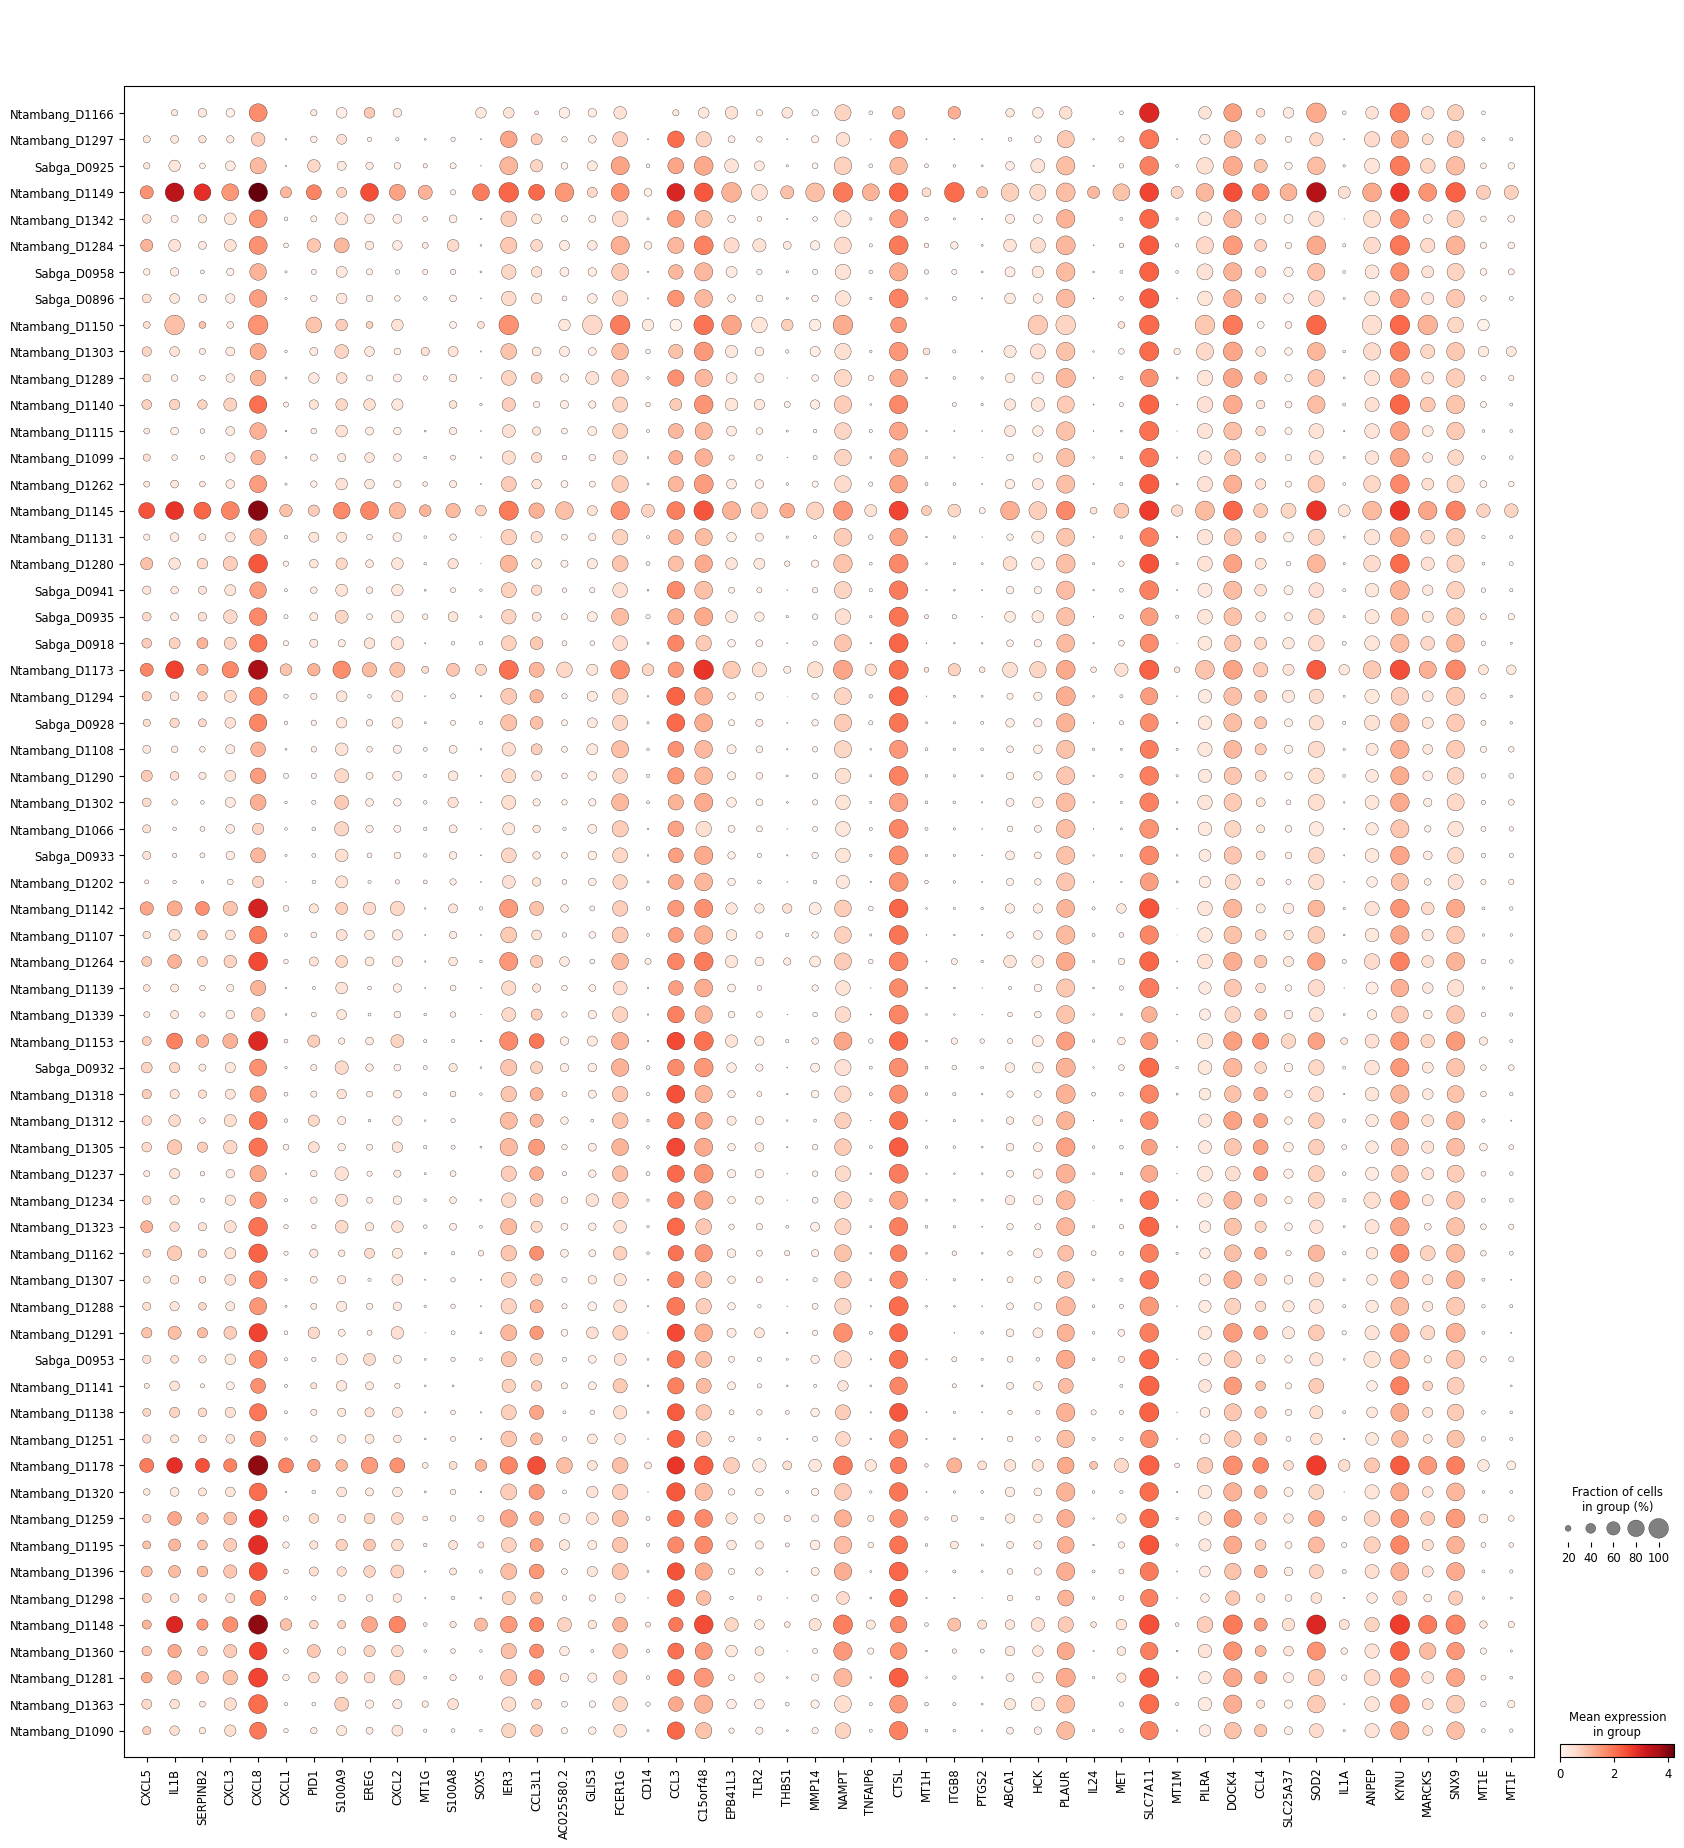

In [15]:
sc.pl.dotplot(spectra_mc[spectra_mc.obs['Ethnicity']=="Tikari"],var_names=spectra.uns['SPECTRA_markers'][24], groupby=['site','FID'])

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


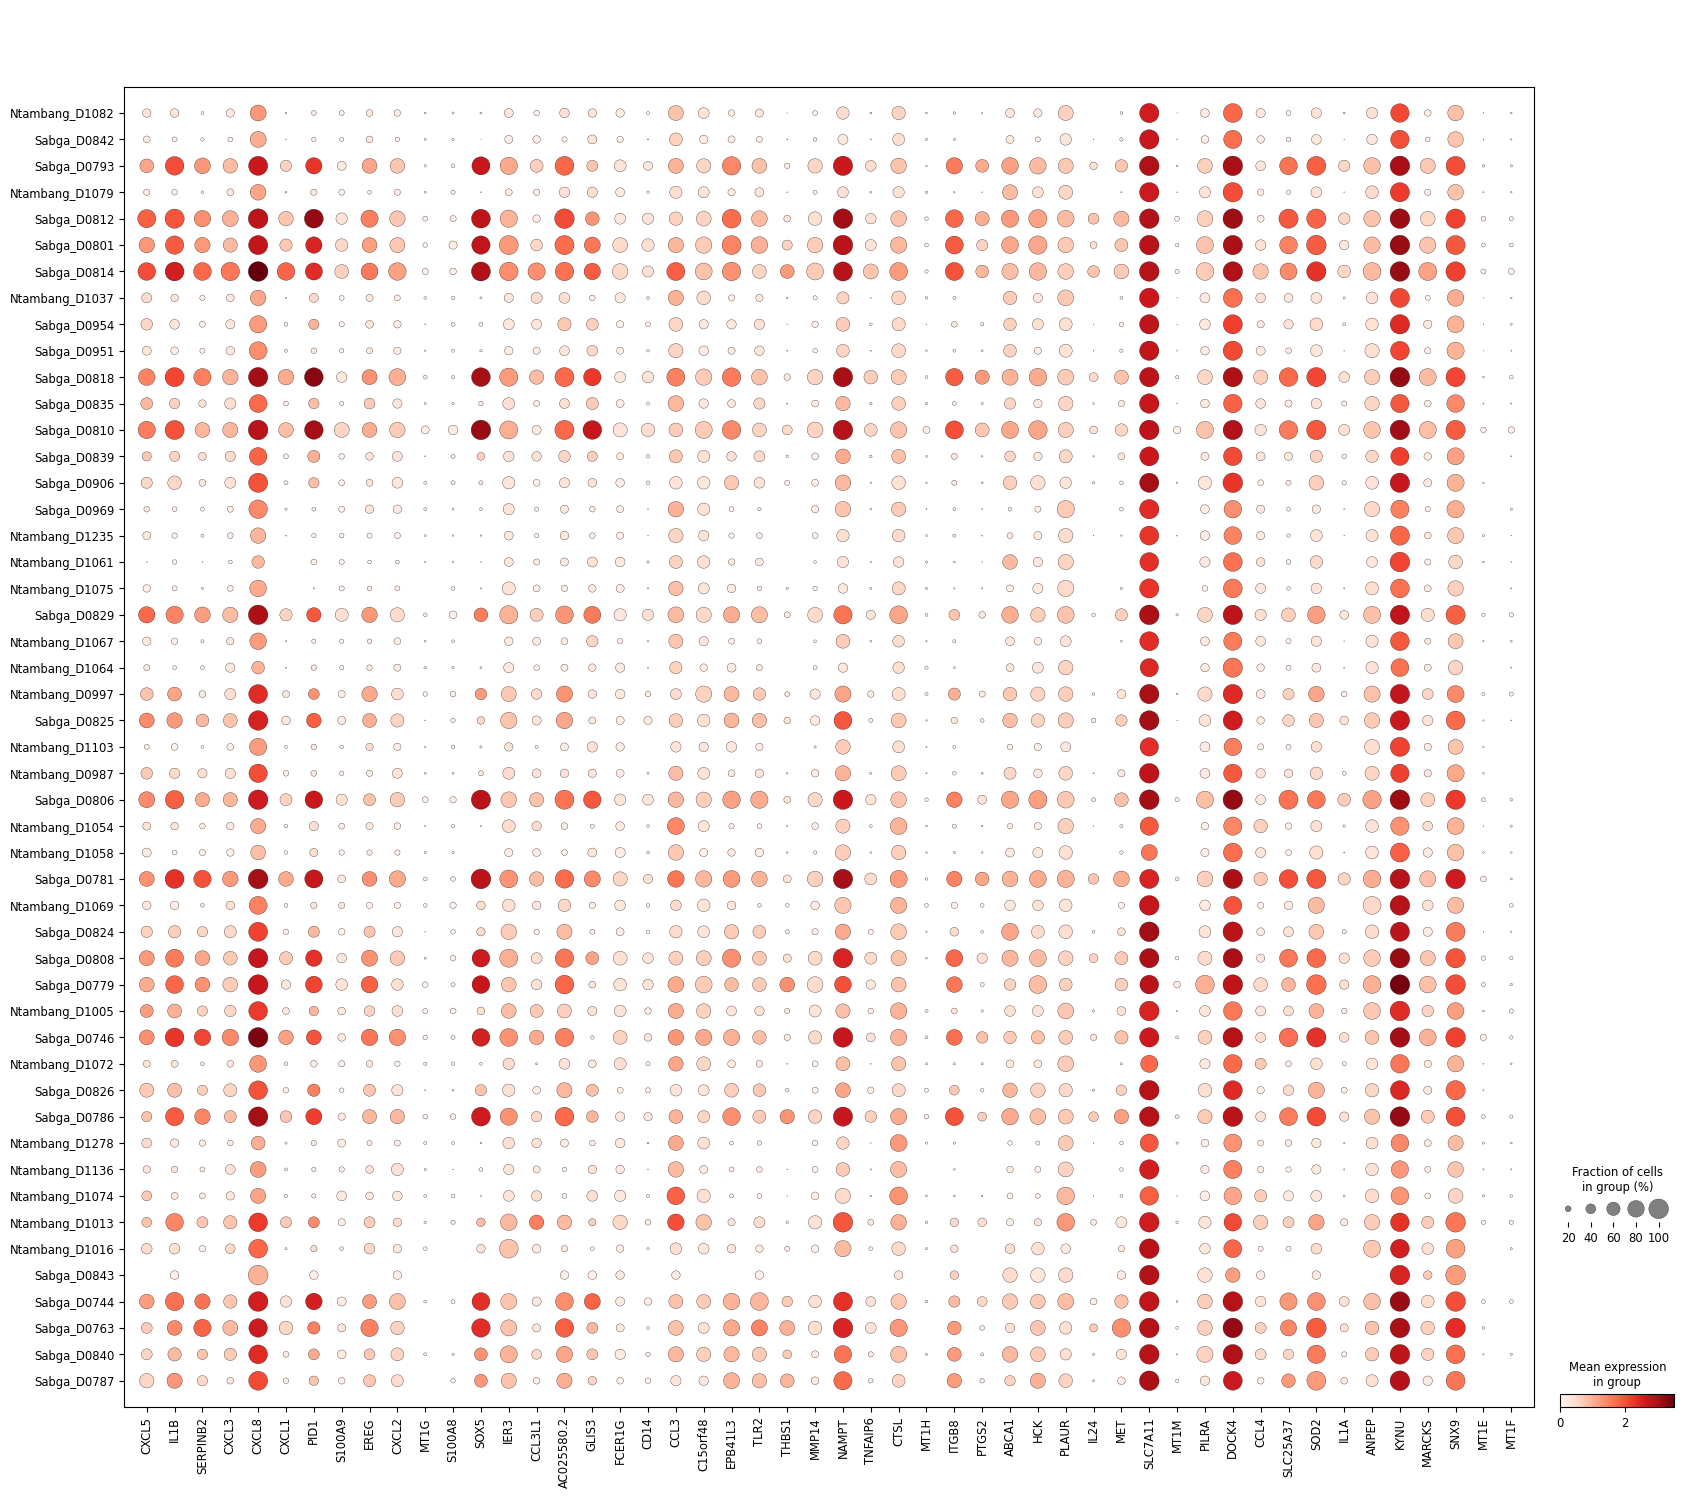

In [16]:
sc.pl.dotplot(rna_raw_mc[rna_raw_mc.obs['Ethnicity']=="Fulani"],var_names=spectra.uns['SPECTRA_markers'][24], groupby=['site','FID'])

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


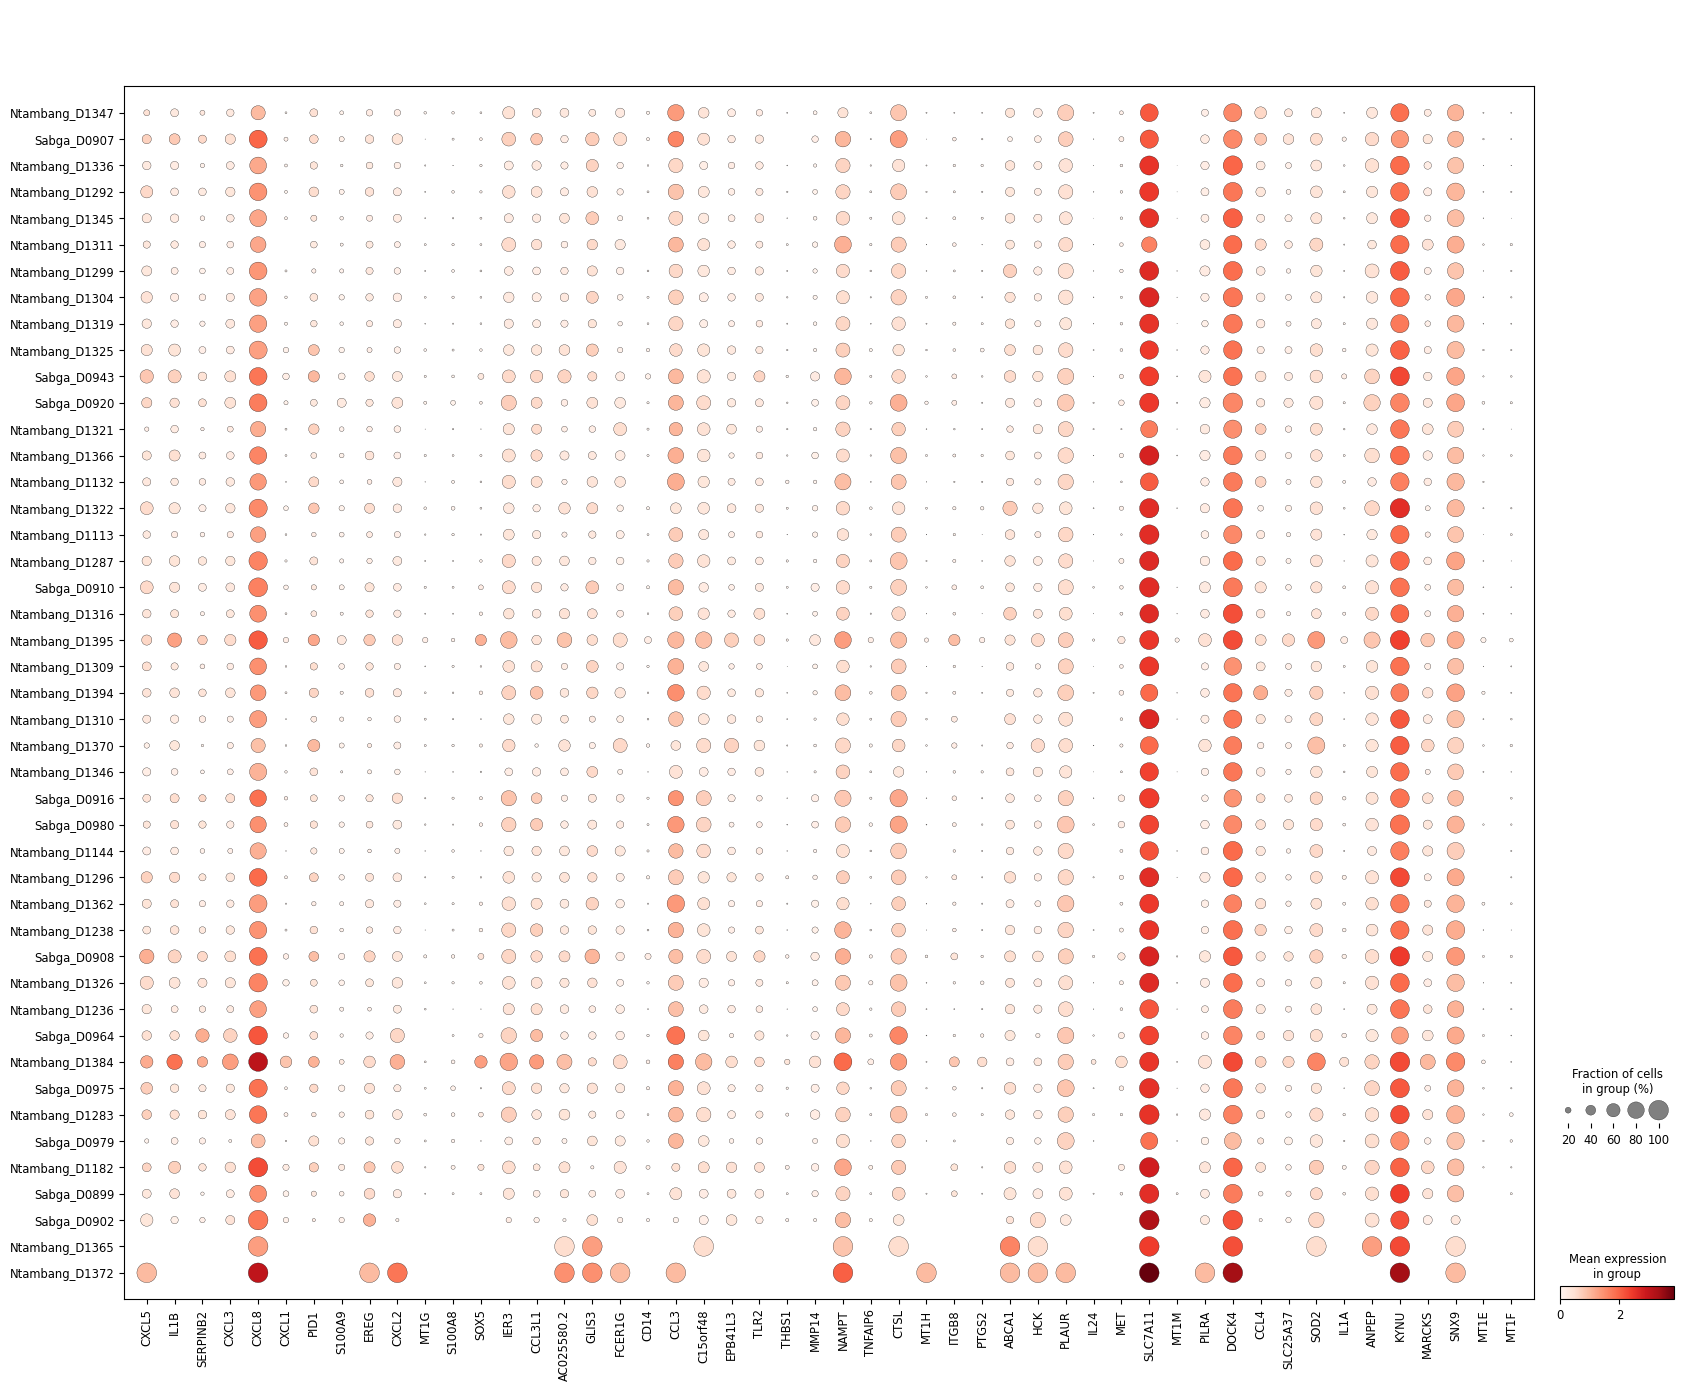

In [17]:
sc.pl.dotplot(rna_raw_mc[rna_raw_mc.obs['Ethnicity']=="Tikari"],var_names=spectra.uns['SPECTRA_markers'][24], groupby=['site','FID'])

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


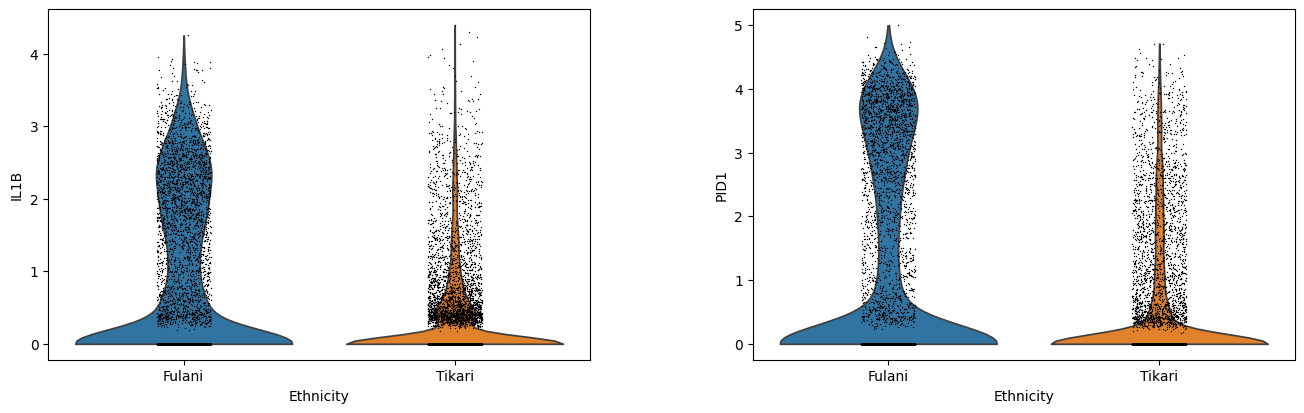

In [221]:
sc.pl.violin(rna_raw[(rna_raw.obs['Cluster_names']=="Myeloid cells") & 
             (rna_raw.obs['COND']=="CTL")],
             keys=['IL1B','PID1'], groupby='Ethnicity')

## Explore data

In [2]:
rna_raw = sc.read_h5ad("write/MR_all.spectra_in.h5ad")

In [4]:
np.sum(rna_raw.var['highly_variable'])

10000

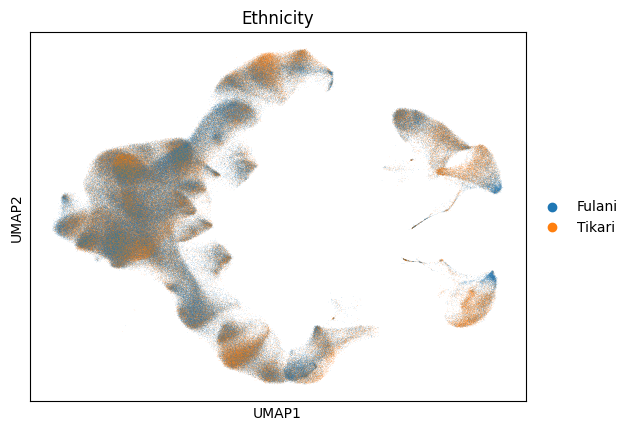

In [43]:
sc.pl.umap(rna_umap, color=['Ethnicity'])

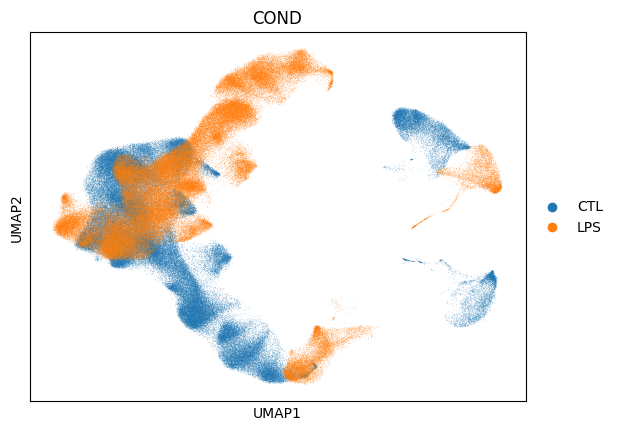

In [19]:
sc.pl.umap(rna_umap[rna_umap.obs['Ethnicity']=="Fulani"], color=['COND'])

In [21]:
site_date = rna_umap.obs[['FID']].merge(site_collect[['FID','site','date']])

In [30]:
rna_umap.obs['site'] = list(site_date['site'])
rna_umap.obs['date'] = list(site_date['date'])

In [34]:
rna_ctl.obs['Cluster_names'].value_counts()

CD4+ T cells             168834
TRAV1-2- CD8+ T cells     61569
NK cells                  28228
B cells                   24854
Myeloid cells             13242
gd T cells                 3683
MAIT cells                 2005
Progenitor cells            485
DN T cells                   29
Name: Cluster_names, dtype: int64

In [67]:
rna_fcm = rna_umap[(rna_umap.obs['Ethnicity']=="Fulani") & (rna_umap.obs['COND']=="CTL") & (rna_umap.obs['Cluster_names']=="Myeloid cells")]
rna_flm = rna_umap[(rna_umap.obs['Ethnicity']=="Fulani") & (rna_umap.obs['COND']=="LPS") & (rna_umap.obs['Cluster_names']=="Myeloid cells")]

In [66]:
rna_tcm = rna_umap[(rna_umap.obs['Ethnicity']=="Tikari") & (rna_umap.obs['COND']=="CTL") & (rna_umap.obs['Cluster_names']=="Myeloid cells")]
rna_tlm = rna_umap[(rna_umap.obs['Ethnicity']=="Tikari") & (rna_umap.obs['COND']=="LPS") & (rna_umap.obs['Cluster_names']=="Myeloid cells")]

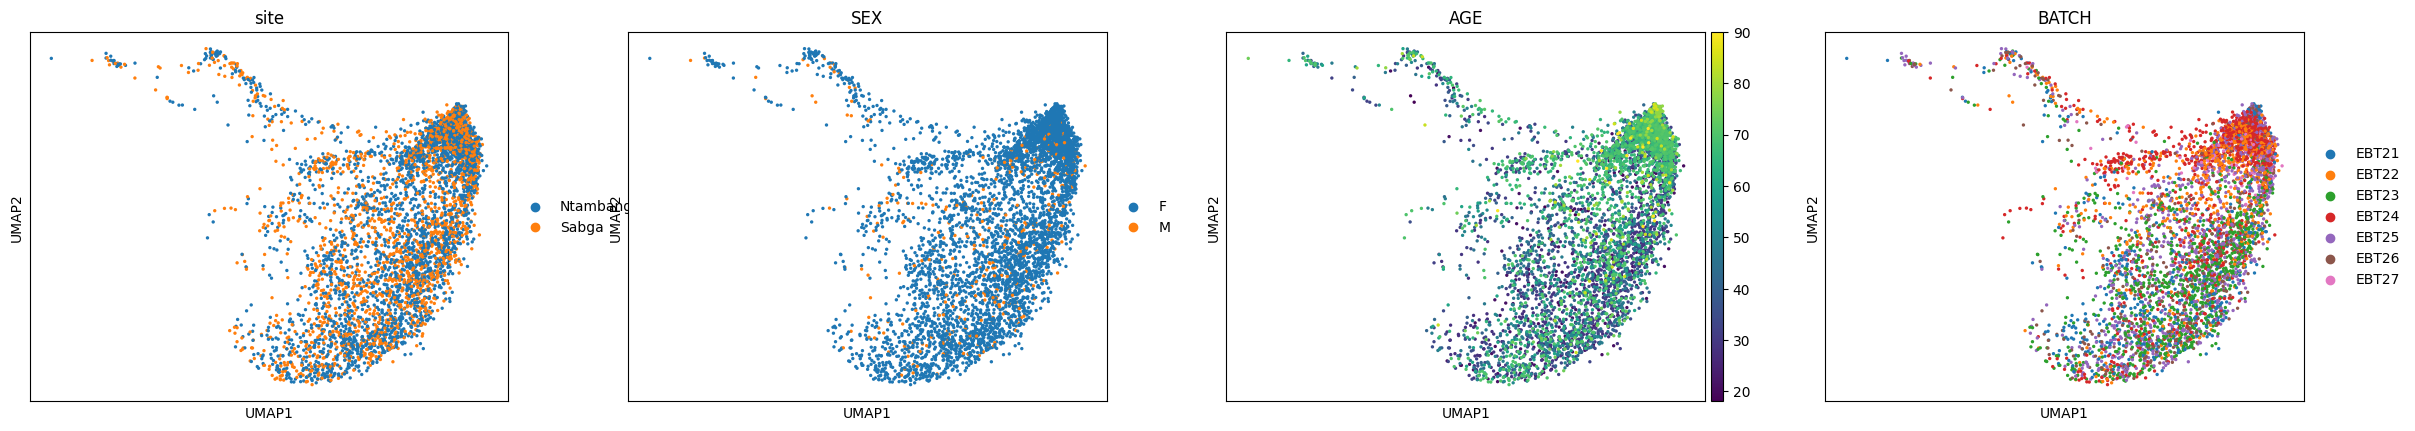

In [41]:
sc.pl.umap(rna_fcm, color=['site','SEX','AGE','BATCH'])

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


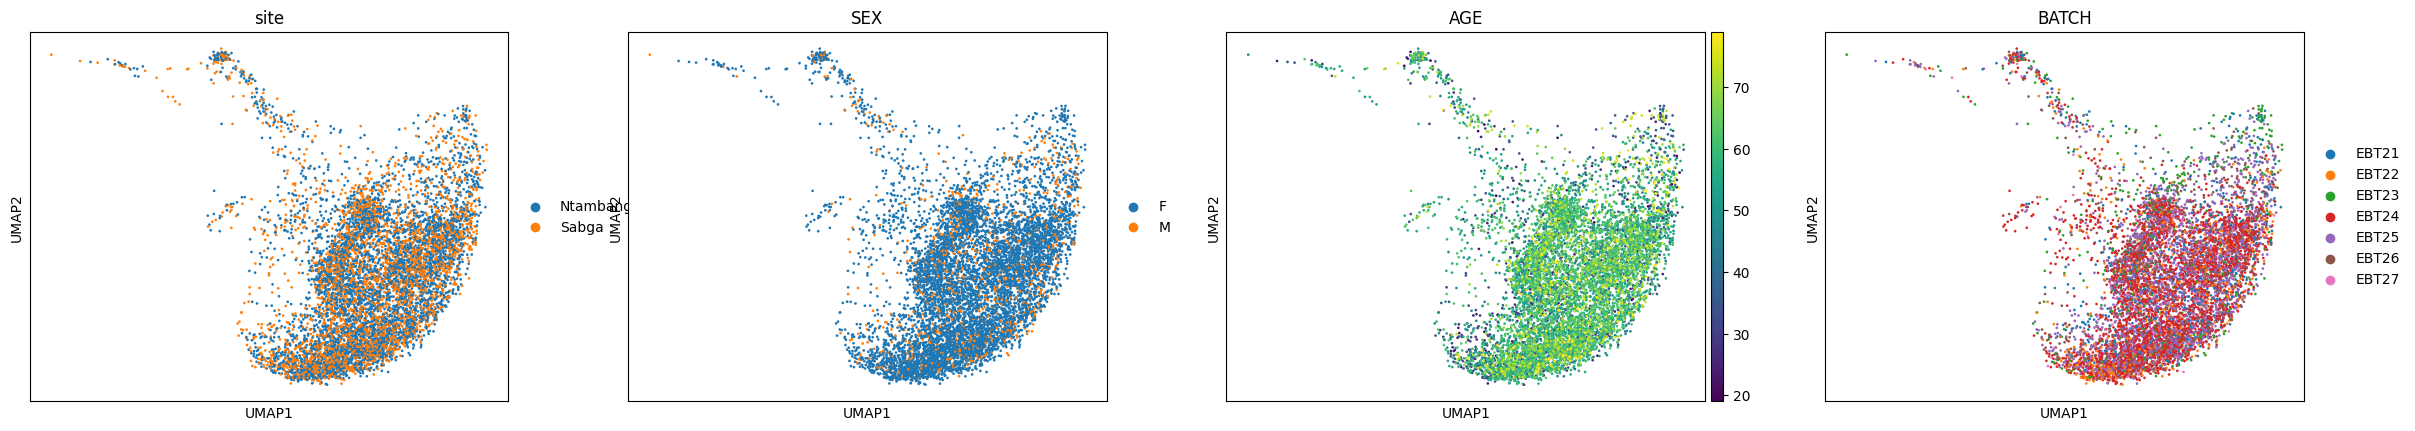

In [55]:
sc.pl.umap(rna_tcm, color=['site','SEX','AGE','BATCH'])

In [60]:
rna_fcm

AnnData object with n_obs × n_vars = 5117 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'donor_id', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity', 'leiden', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'lineage', 'lineage_match', 'site', 'date'
    uns: 'Ethnicity_colors', 'COND_colors', 'leiden_colors', 'site_colors', 'SEX_colors', 'FID_colors', 'BATCH_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'raw_counts'

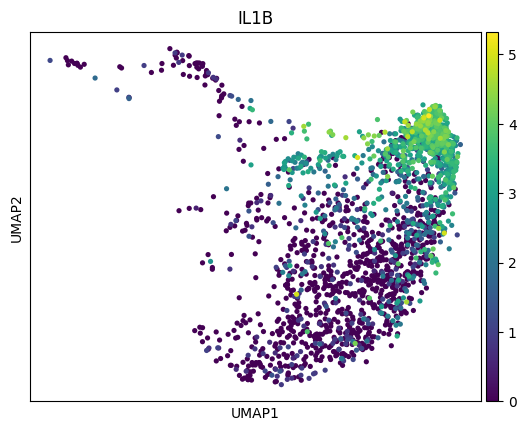

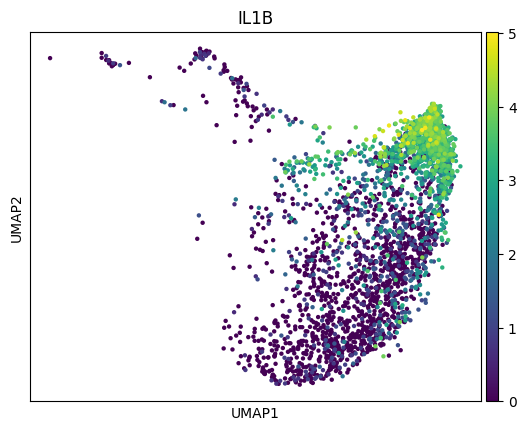

In [64]:
sc.pl.umap(rna_fcm[rna_fcm.obs['site']=="Sabga"], color=['IL1B'])
sc.pl.umap(rna_fcm[rna_fcm.obs['site']=="Ntambang"], color=['IL1B'])

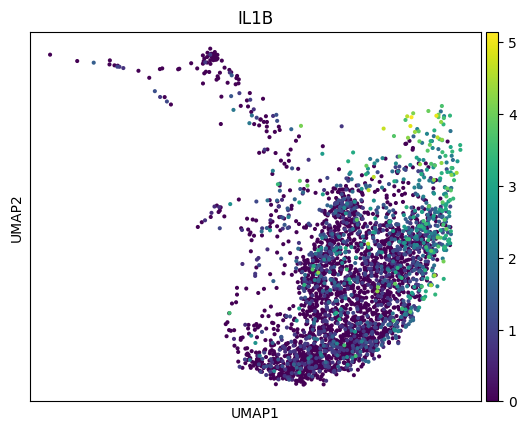

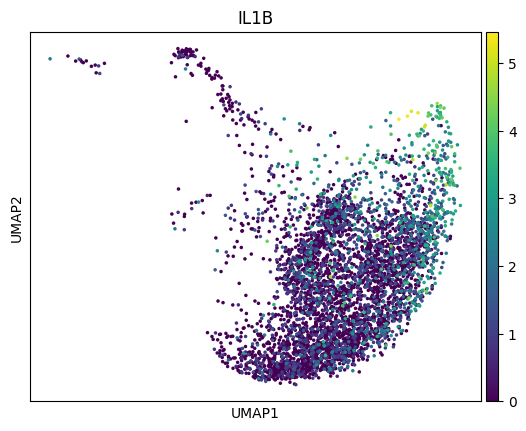

In [65]:
sc.pl.umap(rna_tcm[rna_tcm.obs['site']=="Sabga"], color=['IL1B'])
sc.pl.umap(rna_tcm[rna_tcm.obs['site']=="Ntambang"], color=['IL1B'])

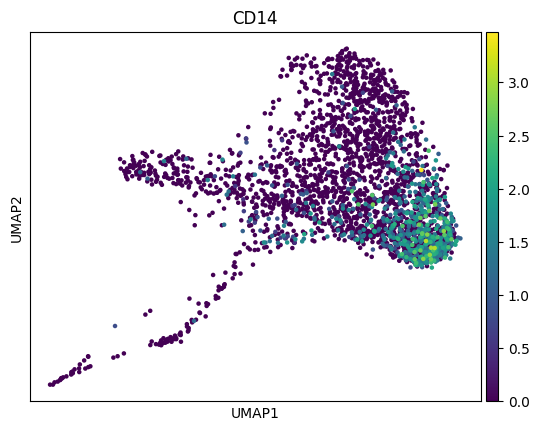

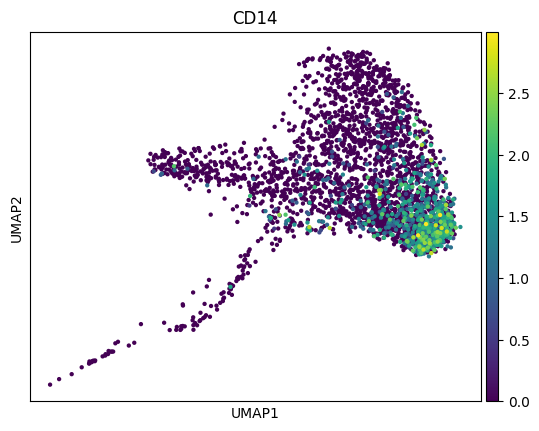

In [77]:
sc.pl.umap(rna_flm[rna_flm.obs['site']=="Sabga"], color=['CD14'])
sc.pl.umap(rna_flm[rna_flm.obs['site']=="Ntambang"], color=['CD14'])

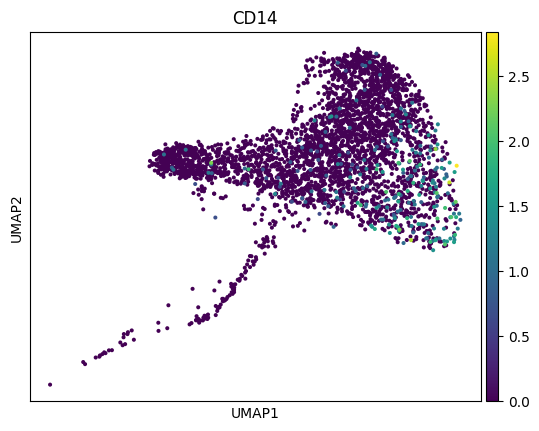

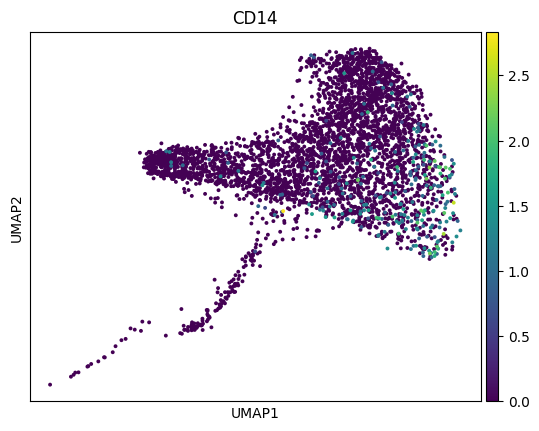

In [78]:
sc.pl.umap(rna_tlm[rna_tlm.obs['site']=="Sabga"], color=['CD14'])
sc.pl.umap(rna_tlm[rna_tlm.obs['site']=="Ntambang"], color=['CD14'])

In [51]:
rna_fcm.obs['date'].value_counts()

2015-08-11 00:00:00    901
2015-06-16 00:00:00    680
2015-08-10 00:00:00    637
2015-08-12 00:00:00    495
2015-06-15 00:00:00    424
2015-07-29 00:00:00    374
2015-06-17 00:00:00    265
2015-07-21 00:00:00    260
2015-07-22 00:00:00    229
2015-07-28 00:00:00    215
2015-07-30 00:00:00    212
2015-07-23 00:00:00    139
2015-07-20 00:00:00    137
2015-08-09 00:00:00     86
2015-07-27 00:00:00     63
Name: date, dtype: int64

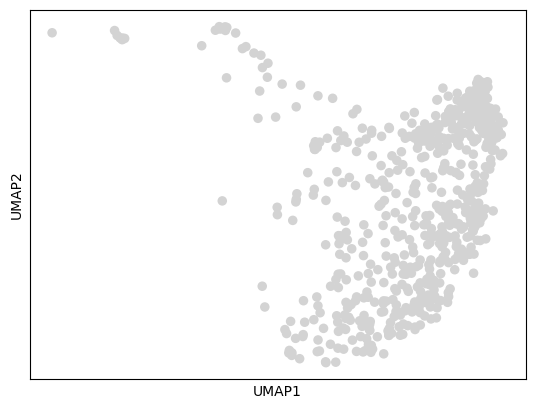

In [53]:
sc.pl.umap(rna_fcm[rna_fcm.obs['date']=="2015-08-10 00:00:00"])

In [5]:
fid_site_date = rna_raw.obs[['FID','Ethnicity']].drop_duplicates().merge(site_collect[['FID','site','date']])

In [13]:
fid_site_date[['Ethnicity','site']].value_counts()

Ethnicity  site    
Tikari     Ntambang    38
Fulani     Sabga       29
           Ntambang    21
Tikari     Sabga       12
dtype: int64

In [17]:
fid_site_date[['site','Ethnicity','date']].value_counts()

site      Ethnicity  date               
Ntambang  Tikari     2015-08-12 00:00:00    12
                     2015-08-11 00:00:00    12
Sabga     Fulani     2015-06-17 00:00:00    10
Ntambang  Fulani     2015-07-29 00:00:00     9
          Tikari     2015-08-10 00:00:00     8
Sabga     Fulani     2015-06-16 00:00:00     8
          Tikari     2015-07-21 00:00:00     5
          Fulani     2015-06-15 00:00:00     5
Ntambang  Fulani     2015-07-27 00:00:00     5
Sabga     Tikari     2015-07-23 00:00:00     4
Ntambang  Fulani     2015-07-28 00:00:00     3
          Tikari     2015-08-09 00:00:00     2
Sabga     Fulani     2015-06-14 00:00:00     2
Ntambang  Tikari     2015-07-30 00:00:00     2
Sabga     Fulani     2015-07-22 00:00:00     2
          Tikari     2015-07-20 00:00:00     2
Ntambang  Fulani     2015-07-30 00:00:00     2
          Tikari     2015-08-07 00:00:00     1
                     2015-08-06 00:00:00     1
          Fulani     2015-08-10 00:00:00     1
                   

In [18]:
adata = sc.read_h5ad("../../test/test123/write/qc_020725_wctypes.harmony.umap.h5ad", backed='r')

In [ ]:
adata